In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus as pp
import seaborn as sns

from IPython.display import display
from IPython.display import Image

from pandas_profiling import ProfileReport

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.decomposition import PCA

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

https://blog.csdn.net/weixin_44405644/article/details/107334270

In [2]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

In [3]:
class CONFIG:
    INDEXS = ["R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]

# Load Dataset

In [4]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [5]:
training_dataset1 = pd.read_csv("Dataset/Training/Features_Variant_1.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])

In [6]:
training_dataset2 = pd.read_csv("Dataset/Training/Features_Variant_2.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])

In [7]:
training_dataset3 = pd.read_csv("Dataset/Training/Features_Variant_3.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])

In [8]:
training_dataset4 = pd.read_csv("Dataset/Training/Features_Variant_4.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])

In [9]:
training_dataset5 = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])

In [10]:
training_dataset = pd.concat((
    training_dataset1,
    training_dataset2,
    training_dataset3,
    training_dataset4,
    training_dataset5)).reset_index(drop=True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602808,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,203
602809,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,42
602810,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,1,0,0,0,51
602811,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,0,0,0,0,0,0,1,0,0,17


In [11]:
training_labels = training_dataset.iloc[:, -1:]
training_labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
602808,203
602809,42
602810,51
602811,17


In [12]:
test_dataset = pd.read_csv("Dataset/Testing/Features_TestSet.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
test_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,0,0,0,1,0,0,1
1,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,1,0,0,0,0,0,0,1,0,0
3,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,1,1,0,0,0,0,0,0,0
4,634995,0,463,1,1.0,17.0,7.000000,2.0,6.663332,1.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10039,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,1
10040,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,13
10041,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,1,0,0,0,0,0,0,1087
10042,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,0,0,1,0,0,0,0,0,14


In [13]:
test_labels = test_dataset.iloc[:, -1:]
test_labels

,Target Variable
0,1
1,0
2,0
3,0
4,1
...,...
10039,1
10040,13
10041,1087
10042,14


# Combine Dataset

In [14]:
n_training_dataset = training_dataset.shape[0]
n_test_dataset = test_dataset.shape[0]
dataset = pd.concat((training_dataset, test_dataset)).reset_index(drop=True)
print("dataset size is : {}".format(dataset.shape))

dataset size is : (612857, 54)


## Add Related Features

In [15]:
post_published_weekday = (dataset["Post published weekday-Monday"]
                          + dataset["Post published weekday-Tuesday"]
                          + dataset["Post published weekday-Wednesday"]
                          + dataset["Post published weekday-Thursday"]
                          + dataset["Post published weekday-Friday"])
post_published_weekend = (dataset["Post published weekday-Sunday"]
                          + dataset["Post published weekday-Saturday"])
dataset.insert(46, "Post published weekday", post_published_weekday)
dataset.insert(47, "Post published weekend", post_published_weekend)

base_datetime_weekday = (dataset["Base DateTime weekday-Monday"]
                          + dataset["Base DateTime weekday-Tuesday"]
                          + dataset["Base DateTime weekday-Wednesday"]
                          + dataset["Base DateTime weekday-Thursday"]
                          + dataset["Base DateTime weekday-Friday"])
base_datetime_weekend = (dataset["Base DateTime weekday-Sunday"]
                          + dataset["Base DateTime weekday-Saturday"])

dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,1,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,1,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,1
612853,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,13
612854,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,0,0,0,0,0,1087
612855,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,14


In [16]:
# profile = ProfileReport(dataset, title="Dataset Report", explorative=True, minimal=True)
# profile.to_file("dataset_report.html")

## Drop Features

In [17]:
dataset = dataset.drop(['Post Promotion Status'], axis=1)
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,1,0,0,0,0,0,0,1,0
1,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,0,0,1,0,0
2,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,0,1,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,806.0,11.291045,1.0,70.495138,0.0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,1
612853,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,13
612854,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,0,1,1,0,0,0,0,0,0,1087
612855,7170111,70,497000,9,0.0,2062.0,482.608696,305.0,511.149322,0.0,...,1,0,0,1,0,0,0,0,0,14


## Data Correlation

In [18]:
dataset.var()

Page Popularity/likes               4.719969e+13
Page Checkinsâ€™s                   4.439737e+08
Page talking about                  1.724050e+10
Page Category                       3.975104e+02
Derived5                            2.788576e+02
Derived6                            2.903892e+05
Derived7                            7.819947e+03
Derived8                            4.919182e+03
Derived9                            7.167330e+03
Derived10                           6.042706e+01
Derived11                           1.895360e+05
Derived12                           1.534872e+03
Derived13                           5.534422e+02
Derived14                           3.009968e+03
Derived15                           1.762798e+01
Derived16                           1.744985e+05
Derived17                           1.021882e+03
Derived18                           2.000451e+02
Derived19                           2.818486e+03
Derived20                           2.617215e+02
Derived21           

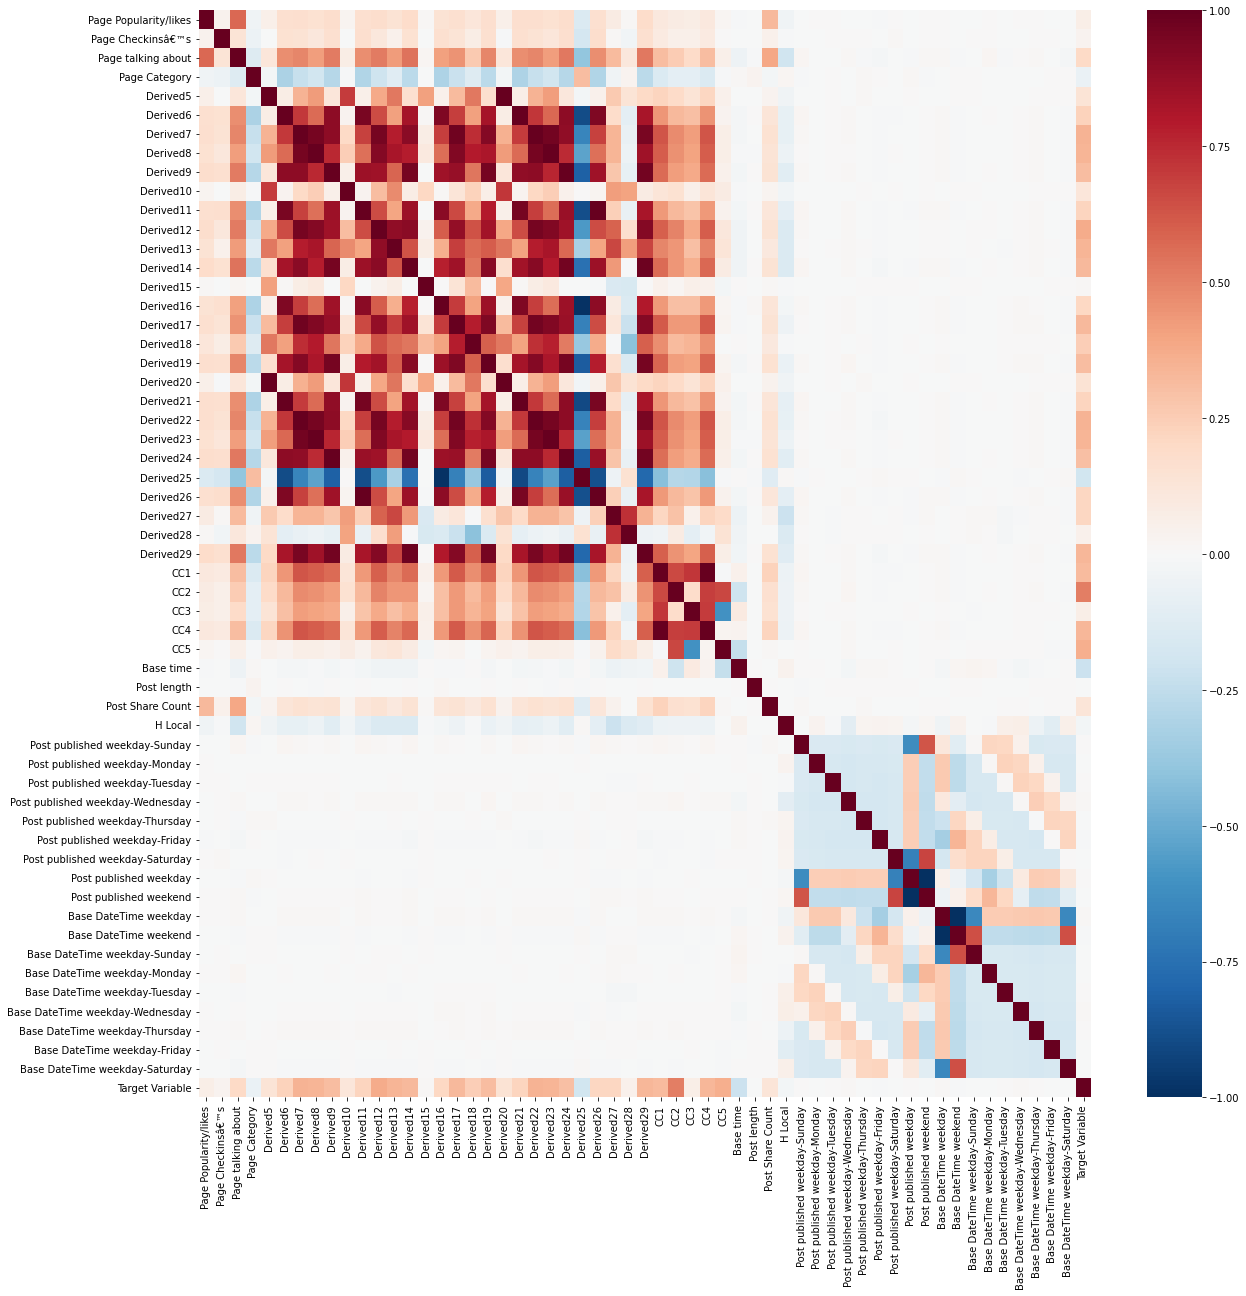

In [19]:
corr = dataset.corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr, cmap="RdBu_r")
plt.show()

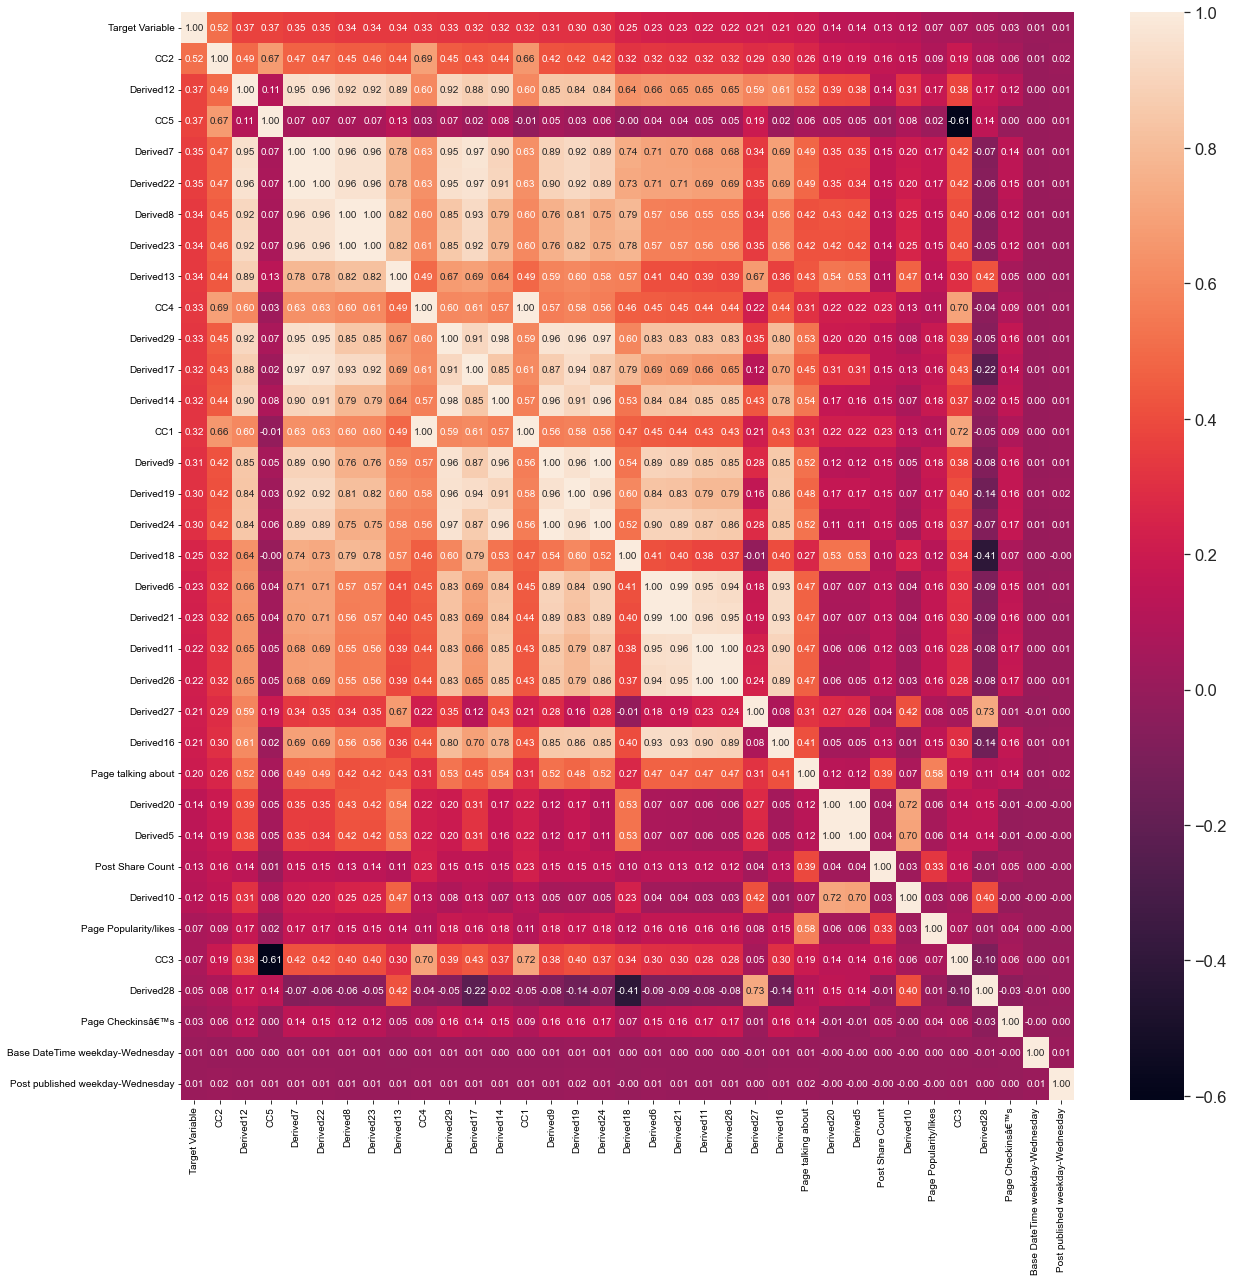

In [20]:
# The 35 most relevant features
plt.subplots(figsize=(20, 20))
c = corr.nlargest(35, 'Target Variable')['Target Variable'].index
cm = np.corrcoef(dataset[c].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=c.values, xticklabels=c.values)
plt.show()

In [21]:
dataset = dataset.drop([
    'Page talking about', #
    'CC1', #
    'CC4', #
    'CC5', #
    'Derived6', #
    'Derived7',
    'Derived8',
    'Derived9',
    'Derived10', #
    'Derived11', #
    'Derived13',
    'Derived14',
    'Derived16', #
    'Derived17',
    'Derived18', #
    'Derived19',
    'Derived20',
    'Derived21', #
    'Derived22',
    'Derived23',
    'Derived24',
    'Derived26', #
    'Derived27', #
    'Derived29'
], axis=1)

dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,...,Base DateTime weekday,Base DateTime weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,3,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,56,424,...,1,0,0,1,0,0,0,0,0,1
612853,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,334,1059,...,1,0,0,1,0,0,0,0,0,13
612854,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,0,0,...,0,1,1,0,0,0,0,0,0,1087
612855,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,550,0,...,1,0,0,1,0,0,0,0,0,14


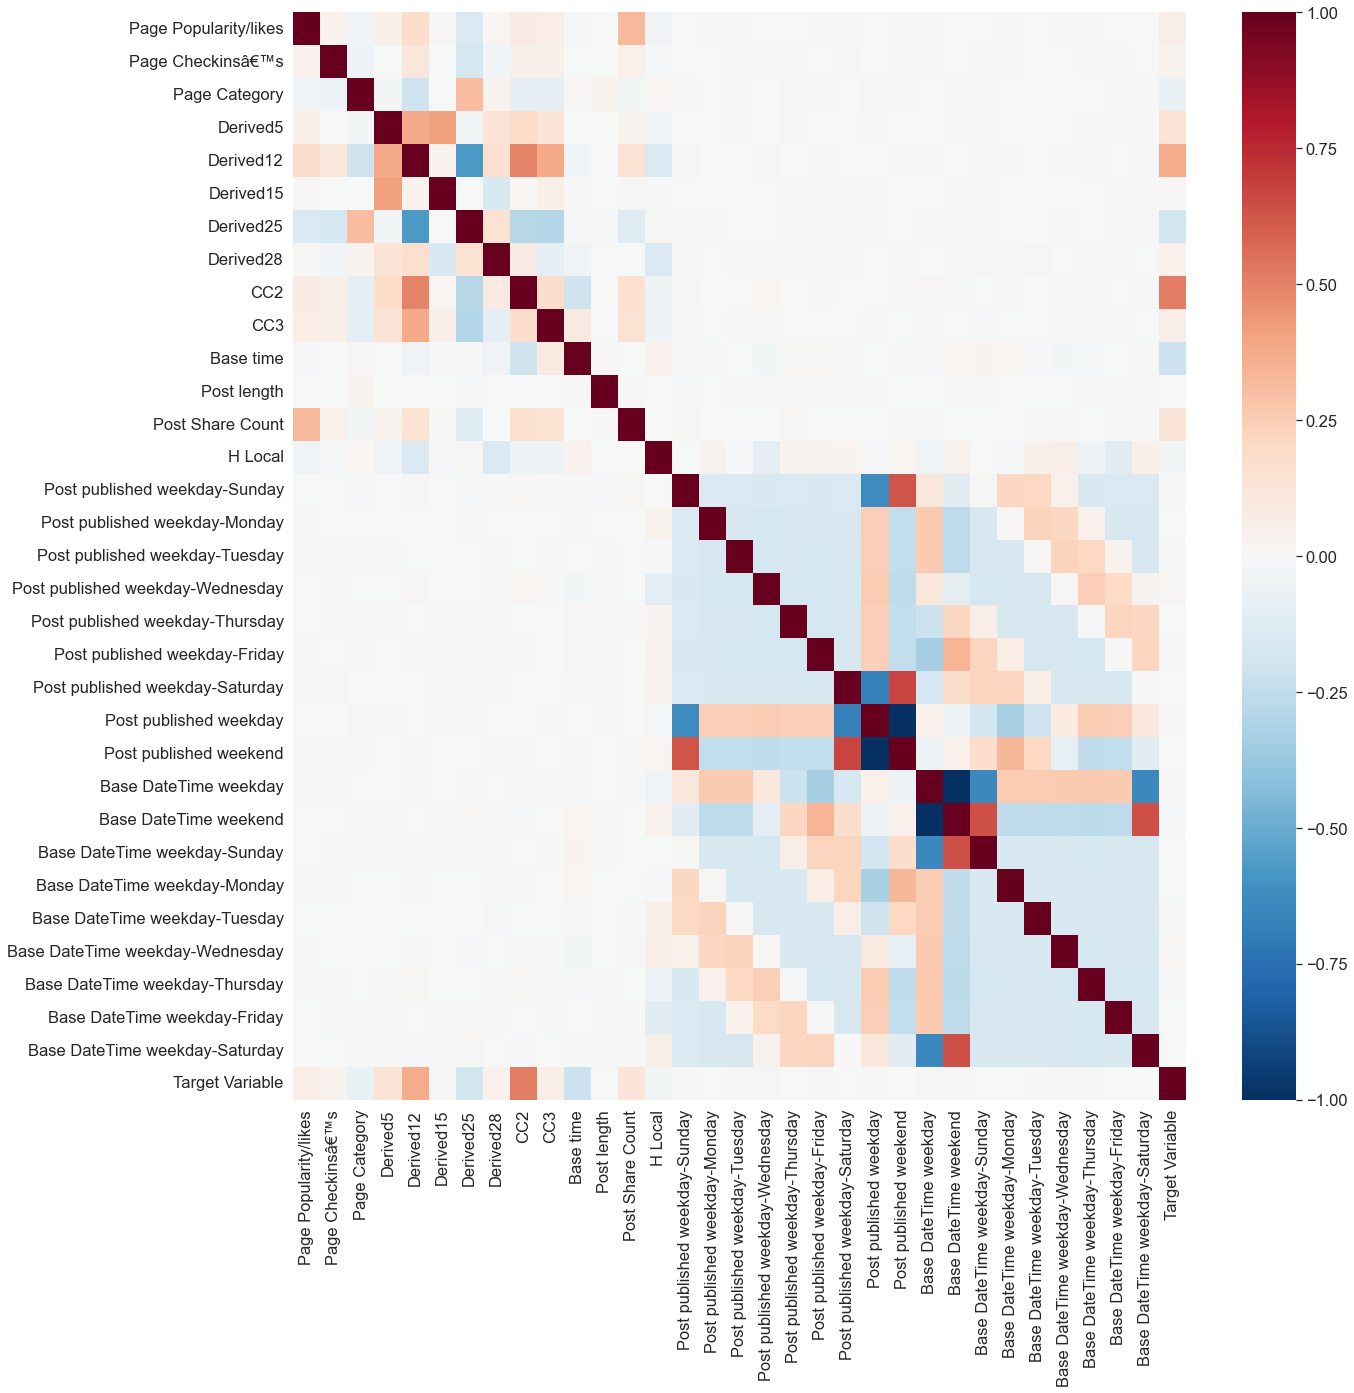

In [22]:
corr = dataset.corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr, cmap="RdBu_r")
plt.show()

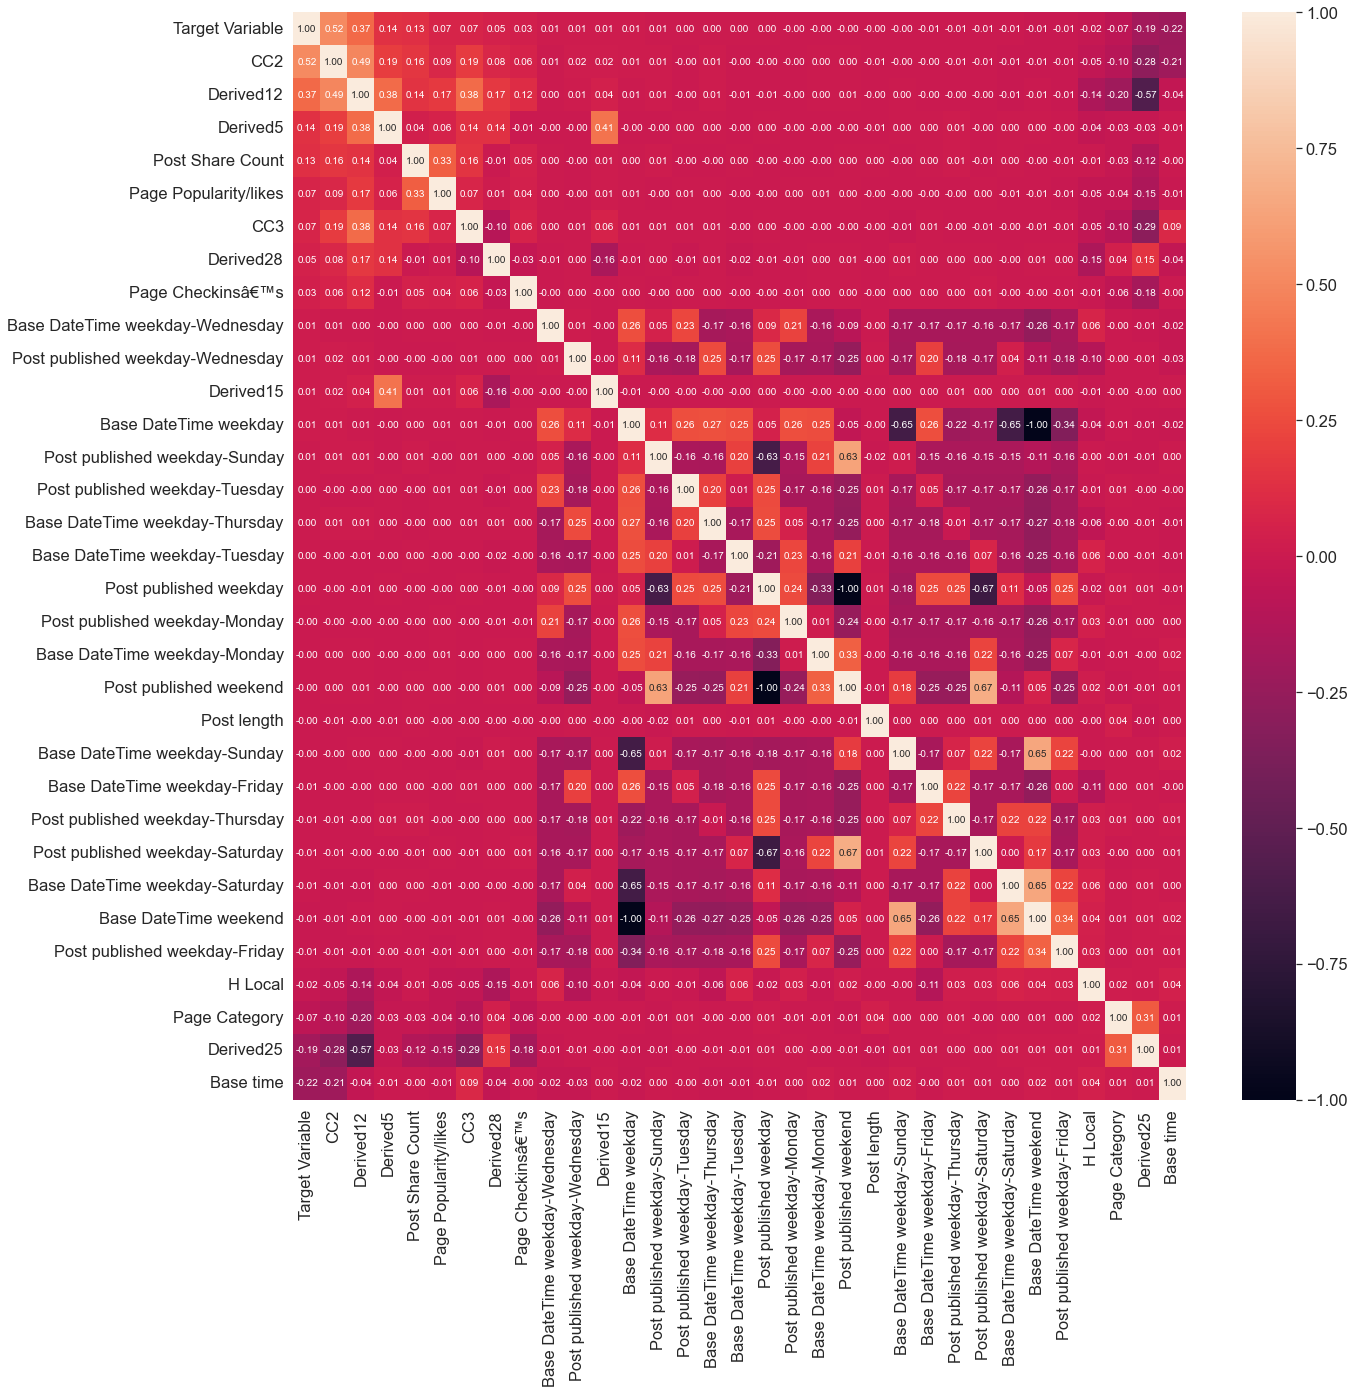

In [23]:
# All most relevant features
plt.subplots(figsize=(20, 20))
c = corr.nlargest(999, 'Target Variable')['Target Variable'].index
cm = np.corrcoef(dataset[c].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=c.values, xticklabels=c.values)
plt.show()

# RF

In [24]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(random_state=1, max_depth=12, min_samples_split=0.0001, n_estimators=60)
# model.fit(dataset.iloc[:, :32], dataset.iloc[:, -1:].values.ravel())

In [25]:
# features = dataset.columns[:-1]
# importances = model.feature_importances_
# indices = np.argsort(importances[0:15])  # top 10 features
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

## RFE

In [26]:
# from sklearn.feature_selection import RFE
# # LGBMRegressor
# model = LGBMRegressor(
#     max_depth=12,
#     n_estimators=720,
#     random_state=42,
# )
# rfe = RFE(model)
# v_transform = rfe.fit_transform(dataset.iloc[:, :32], dataset.iloc[:, -1:].values.ravel())
# rfe.support_

In [27]:
# rfe.ranking_

In [28]:
# dataset[datasxet.columns[rfe.get_support(indices=True)]]

## f_regression

In [29]:
# from sklearn.feature_selection import f_regression
# ffs = f_regression(dataset.iloc[:, :32], dataset.iloc[:, -1:].values.ravel())

# variable = []
# for i in range(0,len(dataset.iloc[:, :32].columns) - 1):
#     if ffs[0][i] >= 100:
#         variable.append(dataset.iloc[:, :32].columns[i])

# variable

In [30]:
dataset = dataset.drop([
    'Post published weekday-Sunday',
    'Post published weekday-Monday',
    'Post published weekday-Tuesday',
#     'Post published weekday-Wednesday',
    'Post published weekday-Thursday',
    'Post published weekday-Friday',
    'Post published weekday-Saturday',
    'Post published weekday',
    'Post published weekend',
    'Base DateTime weekday-Sunday',
    'Base DateTime weekday-Monday',
    'Base DateTime weekday-Tuesday',
#     'Base DateTime weekday-Wednesday',
    'Base DateTime weekday-Thursday',
    'Base DateTime weekday-Friday',
    'Base DateTime weekday-Saturday',
    'Base DateTime weekday',
    'Base DateTime weekend',
], axis=1)

In [31]:
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,Base time,Post length,Post Share Count,H Local,Post published weekday-Wednesday,Base DateTime weekday-Wednesday,Target Variable
0,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,65,166,2,24,1,0,0
1,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,10,132,1,24,0,0,0
2,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,14,133,2,24,0,0,0
3,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,3,62,131,1,24,0,0,0
4,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,58,142,5,24,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,56,424,28,94,287,5,0,0,1
612853,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,334,1059,27,59,1414,6,0,0,13
612854,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,0,0,0,175,673,24,0,0,1087
612855,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,550,0,14,159,124,5,0,0,14


In [32]:
dataset = dataset.drop(['Target Variable'], axis=1)
print("dataset size is : {}".format(dataset.shape))

dataset size is : (612857, 16)


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(dataset)
# Apply transform to both the training set and the test set.
dataset = scaler.transform(dataset)

[0.15930643 0.08835668 0.08393393 0.07572652 0.06862089 0.06560454
 0.06304256 0.06224854 0.05952898 0.05681747 0.05280313 0.04405121
 0.04062278 0.03428191 0.02982582 0.01522861]


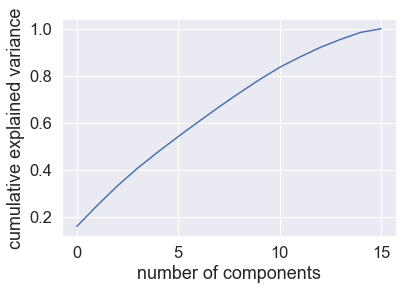

In [35]:
pca = PCA()
pca.fit(dataset)
# pca = PCA(n_components=1)  # 维度降为1
# newData = pca.fit_transform(dataset)
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative Explained Variance');

## Data overview

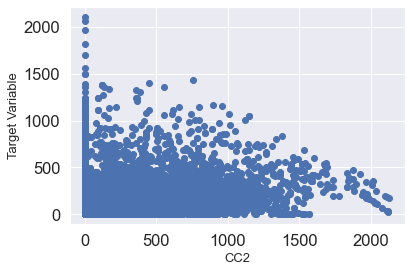

In [33]:
fig, ax = plt.subplots()
ax.scatter(x = training_dataset['CC2'], y = training_dataset['Target Variable'])
plt.ylabel('Target Variable', fontsize=13)
plt.xlabel('CC2', fontsize=13)
plt.show()

/Users/hjj/opt/anaconda3/envs/Facebook-Comment-Volume-Prediction/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 7.16 and sigma = 34.46



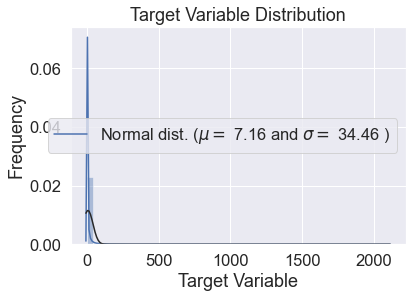

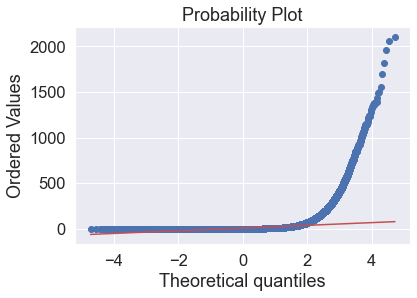

In [34]:
sns.distplot(training_labels['Target Variable'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(training_labels['Target Variable'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Target Variable Distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(training_labels['Target Variable'], plot=plt)
plt.show()

## Box Cox Log-Transformation of Target Variable

In [35]:
# lam = 0.15
# training_labels['Target Variable'] = boxcox1p(training_labels['Target Variable'], lam)

## Log-Transformation of Target Variable

In [36]:
training_labels["Target Variable"] = np.log1p(training_labels["Target Variable"])

/Users/hjj/opt/anaconda3/envs/Facebook-Comment-Volume-Prediction/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.81 and sigma = 1.20



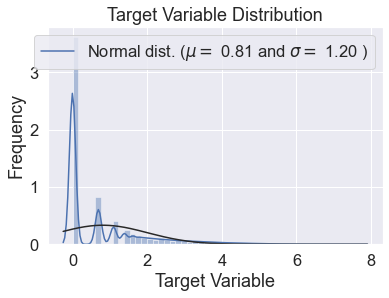

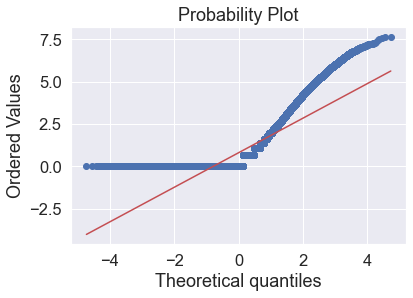

In [37]:
# Check the new distribution 
sns.distplot(training_labels["Target Variable"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(training_labels["Target Variable"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Target Variable Distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(training_labels['Target Variable'], plot=plt)

In [38]:
dataset_na = (dataset.isnull().sum() / len(dataset)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :dataset_na})
missing_data.head()

,Missing Ratio
Page Popularity/likes,0.0
Page Checkinsâ€™s,0.0
Page Category,0.0
Derived5,0.0
Derived12,0.0


## Skewed Features

In [39]:
numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index
numeric_feats

# Check the skew of all numerical features
skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
Derived15,355.315578
Post Share Count,102.823420
Derived5,70.875458
Page Popularity/likes,53.829687
Derived28,25.253586
Post length,19.544159
CC2,9.462433
CC3,9.300835
Page Checkinsâ€™s,7.910320
Derived12,7.190968


## Box Cox Transformation of Highly Skewed Features

We use the scipy function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

In [40]:
dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,Base time,Post length,Post Share Count,H Local,Post published weekday-Wednesday,Base DateTime weekday-Wednesday
0,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,65,166,2,24,1,0
1,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,10,132,1,24,0,0
2,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,14,133,2,24,0,0
3,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,3,62,131,1,24,0,0
4,634995,0,1,0.0,7.574627,0.0,-69.0,0.0,0,0,58,142,5,24,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,56,424,28,94,287,5,0,0
612853,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,334,1059,27,59,1414,6,0,0
612854,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,0,0,0,175,673,24,0,0
612855,7170111,70,9,0.0,242.869565,0.0,-1782.0,77.0,550,0,14,159,124,5,0,0


In [41]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    dataset[feat] = boxcox1p(dataset[feat], lam)

dataset = dataset.fillna(0)
dataset

There are 16 skewed numerical features to Box Cox transform


,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,Base time,Post length,Post Share Count,H Local,Post published weekday-Wednesday,Base DateTime weekday-Wednesday
0,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.000000,0.000000,0.000000,5.831328,7.698683,1.194318,4.137711,0.730463,0.000000
1,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.000000,0.000000,0.000000,2.885846,7.216434,0.730463,4.137711,0.000000,0.000000
2,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.000000,0.000000,0.000000,3.340760,7.232042,1.194318,4.137711,0.000000,0.000000
3,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.000000,0.000000,1.540963,5.744420,7.200727,0.730463,4.137711,0.000000,0.000000
4,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.000000,0.000000,0.000000,5.622899,7.368228,2.055642,4.137711,0.000000,0.730463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,64.493611,5.968981,2.750250,0.0,8.538192,0.0,0.0,6.148461,5.559490,9.859308,4.380946,6.533131,8.922310,2.055642,0.000000,0.000000
612853,64.493611,5.968981,2.750250,0.0,8.538192,0.0,0.0,6.148461,9.279836,12.287497,4.322948,5.653921,13.126816,2.259674,0.000000,0.000000
612854,64.493611,5.968981,2.750250,0.0,8.538192,0.0,0.0,6.148461,0.000000,0.000000,0.000000,7.812236,11.042891,4.137711,0.000000,0.000000
612855,64.493611,5.968981,2.750250,0.0,8.538192,0.0,0.0,6.148461,10.515641,0.000000,3.340760,7.606710,7.087847,2.055642,0.000000,0.000000


In [42]:
# profile = ProfileReport(dataset, title="Dataset with Feature Engineering Report", explorative=True, minimal=True)
# profile.to_file("dataset_with_feature_engineering_report.html")

# Split Dataset

In [43]:
training_dataset = dataset[:n_training_dataset]
test_dataset = dataset[n_training_dataset:]

In [44]:
training_dataset.shape

(602813, 16)

In [45]:
test_dataset.shape

(10044, 16)

In [46]:
training_features = training_dataset
training_features

,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,Base time,Post length,Post Share Count,H Local,Post published weekday-Wednesday,Base DateTime weekday-Wednesday
0,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.0,0.000000,0.000000,5.831328,7.698683,1.194318,4.137711,0.730463,0.000000
1,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.0,0.000000,0.000000,2.885846,7.216434,0.730463,4.137711,0.000000,0.000000
2,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.0,0.000000,0.000000,3.340760,7.232042,1.194318,4.137711,0.000000,0.000000
3,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.0,0.000000,1.540963,5.744420,7.200727,0.730463,4.137711,0.000000,0.000000
4,42.801338,0.000000,0.730463,0.0,2.535520,0.0,0.0,0.0,0.000000,0.000000,5.622899,7.368228,2.055642,4.137711,0.000000,0.730463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602808,64.493611,5.968981,2.750250,0.0,8.406855,0.0,0.0,0.0,14.087847,0.000000,3.530419,6.148461,14.370242,4.137711,0.000000,0.730463
602809,64.493611,5.968981,2.750250,0.0,8.406855,0.0,0.0,0.0,7.552608,0.000000,1.820334,7.184917,10.137338,4.137711,0.000000,0.730463
602810,64.493611,5.968981,2.750250,0.0,8.406855,0.0,0.0,0.0,8.179634,0.000000,3.128239,3.128239,13.324655,4.137711,0.730463,0.730463
602811,64.493611,5.968981,2.750250,0.0,8.406855,0.0,0.0,0.0,6.337529,10.487444,4.545286,7.469200,12.393103,4.137711,0.730463,0.000000


In [47]:
test_features = test_dataset
test_features

,Page Popularity/likes,Page Checkinsâ€™s,Page Category,Derived5,Derived12,Derived15,Derived25,Derived28,CC2,CC3,Base time,Post length,Post Share Count,H Local,Post published weekday-Wednesday,Base DateTime weekday-Wednesday
602813,42.801338,0.000000,0.730463,0.730463,2.055642,0.0,0.0,1.194318,1.194318,0.000000,1.194318,6.314735,1.194318,4.137711,0.0,0.0
602814,42.801338,0.000000,0.730463,0.730463,2.055642,0.0,0.0,1.194318,1.194318,0.000000,3.237728,6.426513,0.730463,4.137711,0.0,0.0
602815,42.801338,0.000000,0.730463,0.730463,2.055642,0.0,0.0,1.194318,0.730463,0.000000,1.194318,7.538898,0.730463,0.730463,0.0,0.0
602816,42.801338,0.000000,0.730463,0.730463,2.055642,0.0,0.0,1.194318,1.540963,2.885846,4.492018,6.986732,1.194318,4.137711,0.0,0.0
602817,42.801338,0.000000,0.730463,0.730463,2.055642,0.0,0.0,1.194318,3.618223,0.000000,3.618223,7.909100,0.730463,3.237728,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612852,64.493611,5.968981,2.750250,0.000000,8.538192,0.0,0.0,6.148461,5.559490,9.859308,4.380946,6.533131,8.922310,2.055642,0.0,0.0
612853,64.493611,5.968981,2.750250,0.000000,8.538192,0.0,0.0,6.148461,9.279836,12.287497,4.322948,5.653921,13.126816,2.259674,0.0,0.0
612854,64.493611,5.968981,2.750250,0.000000,8.538192,0.0,0.0,6.148461,0.000000,0.000000,0.000000,7.812236,11.042891,4.137711,0.0,0.0
612855,64.493611,5.968981,2.750250,0.000000,8.538192,0.0,0.0,6.148461,10.515641,0.000000,3.340760,7.606710,7.087847,2.055642,0.0,0.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels, test_size=.3, random_state=42)

# LightGBM

## Model Training

In [49]:
def create_model():
    # LGBMRegressor
    model = LGBMRegressor(
        max_depth=12,
        n_estimators=720,
        random_state=42,
    )
    return model

In [50]:
def train_model(model):
    model.fit(X_train, y_train.values.ravel())
    return model

In [51]:
def predict(model, X):
    pred = model.predict(X)
    return pred

In [52]:
def plot_test_predict(y_test, predict, axes=None, k=None):
    test_predict = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(predict.transpose())], axis=1)
    headers = ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict.sample(n=200), ax=axes[k]).set_title("Test Predict Curve k = " + str(k))
    else:
        sns.lineplot(data=test_predict.sample(n=200)).set_title("Test Predict Curve")
    plt.show()
    sns.residplot(x=predict, y=y_test.to_numpy(), lowess=True).set_title("Residuals")
    plt.show()
    y_test_np = y_test.to_numpy().flatten()
    sns.residplot(x=predict, y=y_test_np * (predict - y_test_np), lowess=True).set_title("Residuals")
    plt.show()

## Model Evaluation

In [53]:
def evaluate(model, y_test, predict):

    # R-Squared
    r2 = r2_score(y_test, predict)
    
    # Explained Variance Score
    ev = explained_variance_score(y_test, predict)
    
    # Max Error
    me = max_error(y_test, predict)
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_test, predict)
    
    # Mean Squared Error
    mse = mean_squared_error(y_test, predict)
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predict)
    
    # Hit@10
    y_test_np = y_test.to_numpy().flatten()
    hit = np.abs(y_test_np - predict) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_test.to_numpy().flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(predict)
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [54]:
def train_final_model():
    
    model = create_model()

    # Model Training
    model = train_model(model)
    pred = predict(model, X_test)
#     plot_test_predict(np.expm1(y_test), np.expm1(pred))
#     plot_test_predict(y_test, pred)

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, np.expm1(y_test), np.expm1(pred))

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)
    
    return model

In [55]:
model = train_final_model()

       Index         Mean
0         R2     0.760927
1         EV     0.762008
2         ME  1223.012471
3    MEAN_AE     2.927149
4        MSE   267.640351
5  MEDIAN_AE     0.354637
6     HIT@10     0.947684
7    HIT@100     0.470000


# Model Testing

In [56]:
def test():
    pred = predict(model, test_features)
    plot_test_predict(test_labels, np.expm1(pred))

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, test_labels, np.expm1(pred))

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

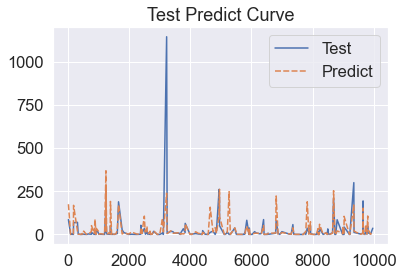

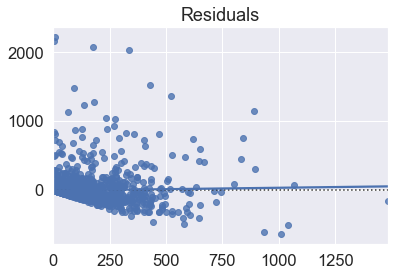

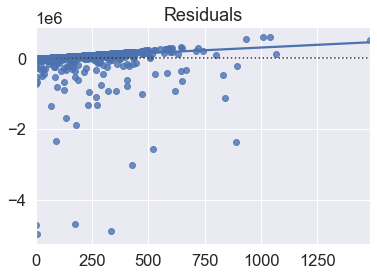

       Index         Mean
0         R2     0.473996
1         EV     0.474884
2         ME  2228.406306
3    MEAN_AE    18.551142
4        MSE  6959.759627
5  MEDIAN_AE     1.835147
6     HIT@10     0.765034
7    HIT@100     0.410000


In [57]:
test()